# Access community-contributed embeddings

This notebook demonstrates basic access to community-contributed, CELLxGENE-hosted embeddings of the Census.

**IMPORTANT:** this notebook requires tiledbsoma version 1.5 or greater.

## Contents

1. Background
2. Metadata
3. Query cells and load associated embeddings
4. Load embeddings and fetch associated Census data

> ⚠️ Note that the Census RNA data includes duplicate cells present across multiple datasets. Duplicate cells can be filtered in or out using the cell metadata variable `is_primary_data` which is described in the [Census schema](https://github.com/chanzuckerberg/cellxgene-census/blob/main/docs/cellxgene_census_schema.md#repeated-data).

## Background

This notebook demonstrates access to community-contributed embeddings of the Census. The Census has multiple releases, named by a `census_version`, which normally looks like an ISO date, e.g., `2023-02-01`. A community-contributed embedding is a 2D sparse matrix of cell embeddings _for a given census version_, encoded as a SOMA SparseNDArray.

## Storage format

Each embedding is encoded as a SOMA SparseNDArray, where:
* dimension 0 (`soma_dim_0`) encodes the cell (obs) `soma_joinid` value
* dimension 1 (`soma_dim_1`) encodes the embedding feature, and is in the range [0, N) where N is the number of featues in the embedding
* data (`soma_data`) is float32

⚠️ **IMPORTANT:** Community-contributed embeddings may embed a subset of the cells in any given Census version. If a cell has an embedding, it will be explicitly stored in the sparse array, _even if the embedding value is zero_. In other words, missing array values values imply that the cell was not embedded, whereas zero valued embeddings are explicitly stored. Put another way, the `nnz` of the embedding array indicate the number of embedded cells, not the number of non-zero values.

The first axis of the embedding array will have the same shape as the corresponding `obs` DataFrame for the Census build and experiment. The second axis of the embedding will have a shape (0, N) where N is the number of features in the embedding.

Embedding values, while stored as a float32, are precision reduced. Currently they are equivalent to a bfloat16, i.e., have 8 bits of exponent and 7 bits of mantissa.

## Metadata

Each embedding will contain a variety of metadata stored in the SOMA `metadata` slot, encoded as a JSON string. This metadata includes several important fields, including:
* census_version - the Census which is embedded. It is critical to confirm this matches the Census in use, or the embeddings will be meaningless.
* experiment_name - the Census experiment embedded, e.g., `homo_sapiens` or `mus_musculus`.
* measurement_name - the Census measurement embedded, e.g., `RNA`

There are a variety of other metadata values encoded, as [documented here](link???).


In [1]:
import json

import tiledbsoma as soma


def soma_context() -> soma.options.SOMATileDBContext:
    """
    Helper function. Returns a config which uses larger I/O buffers and reads from AWS S3 us-west-2 region.
    """
    return soma.options.SOMATileDBContext(
        tiledb_config={
            "soma.init_buffer_bytes": 4 * 1024**3,
            "py.init_buffer_bytes": 4 * 1024**3,
            "vfs.s3.region": "us-west-2",
        }
    )


# TODO: replace this with accessible URI at some point
EMBEDDING_URI = "../../../../tmp/CxG-contrib-1/CxG-contrib-1/"

with soma.open(EMBEDDING_URI, context=soma_context()) as E:
    # read embedding metadata and decode the JSON-encoded data
    embedding_metadata = json.loads(E.metadata["CxG_contrib_metadata"])

census_version = embedding_metadata["census_version"]
experiment_name = embedding_metadata["experiment_name"]

embedding_metadata

{'id': 'CxG-contrib-1',
 'title': 'scGPT: Towards Building a Foundation Model for Single-Cell Multi-omics Using Generative AI',
 'description': 'Utilizing the burgeoning single-cell sequencing data, we have pioneered the construction of a foundation model for single-cell biology, scGPT, which is based on generative pre-trained transformer across a repository of over 33 million cells. Our findings illustrate that scGPT, a generative pre-trained transformer, effectively distills critical biological insights concerning genes and cells. Through the further adaptation of transfer learning, scGPT can be optimized to achieve superior performance across diverse downstream applications.\n',
 'contact_name': 'Bo Wang',
 'contact_email': 'bowang@vectorinstitute.ai',
 'contact_affiliation': 'Bo Wang Lab, University of Toronto',
 'DOI': '10.1101/2023.04.30.538439',
 'additional_information': '',
 'model_link': 'https://github.com/bowang-lab/scGPT',
 'data_type': 'obs_embedding',
 'census_version': 

## Query cells and load associated embeddings

This demonstrates several methods to query cells from the Census by `obs` metadata, and then fetch embeddings associated with each cell.

Demos:
1. load the embedding into a dense NumPy array
2. load the embedding into an AnnData `obsm` slot

In [2]:
# Demo 1A: select cells from the Census based on obs metadata. Given the resulting cells,
# use their soma_joinids to slice from embedding, and save as a dense NDArray.

import cellxgene_census
import numpy as np
import tiledbsoma as soma
from IPython.display import Markdown


# First, query for the cells of interest based upon metadata and save as a
# Pandas DataFrame.
#
with cellxgene_census.open_soma(census_version=census_version) as census:
    experiment = census["census_data"][experiment_name]
    obs_df = (
        experiment.obs.read(
            value_filter="""tissue_general == 'exocrine gland'""",
            column_names=[
                "soma_joinid",
                "cell_type",
                "suspension_type",
                "tissue_general",
            ],
        )
        .concat()
        .to_pandas()
    )

display(obs_df)

# Extract embedddings for the selected cells, into a 2D NDArray of values,
# and a 1D array of joinids.
#
with soma.open(EMBEDDING_URI, context=soma_context()) as E:
    # read embedding and obs joinids
    obs_joinids_to_query = obs_df.soma_joinid.to_numpy()

    embedding_joinids = None
    embedding_data = None

    for d, (obs_joinids, _) in E.read(coords=(obs_joinids_to_query,)).blockwise(axis=0).scipy():
        # Any row in the matrix missing values (i.e., nnz of the row is zero) lacks an
        # embedding. Drop these cells from both the embedding matrix and joinids array.
        embedding_presence_mask = d.getnnz(axis=1) != 0
        obs_joinids = obs_joinids[embedding_presence_mask]
        d = d[embedding_presence_mask, :]

        d = d.toarray()  # densify
        embedding_data = np.vstack([embedding_data, d]) if embedding_data is not None else d
        embedding_joinids = (
            np.concatenate((embedding_joinids, obs_joinids)) if embedding_joinids is not None else obs_joinids
        )

# Each cell embedding is positionally indexed
display(Markdown("**First few cells, metadata and cell embedding**"))
display(obs_df.iloc[0:3])
display(embedding_data[0:3, 0:4])

,soma_joinid,cell_type,suspension_type,tissue_general
0,8281739,acinar cell of salivary gland,cell,exocrine gland
1,8281740,acinar cell of salivary gland,cell,exocrine gland
2,8281741,naive B cell,cell,exocrine gland
3,8281742,memory B cell,cell,exocrine gland
4,8281743,memory B cell,cell,exocrine gland
...,...,...,...,...
115717,52551944,acinar cell of salivary gland,cell,exocrine gland
115718,52551945,duct epithelial cell,cell,exocrine gland
115719,52551946,acinar cell of salivary gland,cell,exocrine gland
115720,52551947,duct epithelial cell,cell,exocrine gland


**First few cells, metadata and cell embedding**

,soma_joinid,cell_type,suspension_type,tissue_general
0,8281739,acinar cell of salivary gland,cell,exocrine gland
1,8281740,acinar cell of salivary gland,cell,exocrine gland
2,8281741,naive B cell,cell,exocrine gland


array([[-0.00506607, -0.01351103, -0.03183845, -0.02330936],
       [ 0.02407768, -0.02444823, -0.00595252, -0.00658417],
       [ 0.0007065 ,  0.00187382, -0.04660113, -0.04614013]],
      dtype=float32)

In [6]:
# Demo 1B: The same method can be used to query an AnnData from the Census, and
# add the embedding as an `obsm` layer on the AnnData.

# NOTE: this demo creates an AnnData matching a Census obs metadata query, but
# drops any cells which do not have an embedding.

import cellxgene_census
import scipy.sparse as sp
import tiledbsoma as soma

with cellxgene_census.open_soma(census_version=census_version) as census:
    experiment = census["census_data"][experiment_name]
    with experiment.axis_query(
        measurement_name="RNA",
        obs_query=soma.AxisQuery(value_filter="tissue_general in ['spinal cord']"),
        var_query=soma.AxisQuery(coords=(slice(0, 1),)),  # we don't use X data, so minimize load memory & time
    ) as query:
        # Load AnnData and X[raw]
        adata = query.to_anndata(X_name="raw")
        obs_joinids_to_query = query.obs_joinids().to_numpy()

    # Load embedding associated with the obs joinids
    with soma.open(EMBEDDING_URI, context=soma_context()) as E:
        # read embedding and obs joinids
        embeddings = sp.vstack(
            [
                blk
                for blk, _ in (
                    E.read(coords=(obs_joinids_to_query,))
                    .blockwise(axis=0, size=2**20, reindex_disable_on_axis=1)
                    .scipy()
                )
            ]
        )

    embedding_presence_mask = embeddings.getnnz(axis=1) != 0
    embeddings = embeddings[embedding_presence_mask, :].toarray()
    adata = adata[embedding_presence_mask, :]

    adata.obsm["an_embedding"] = embeddings

adata

AnnData object with n_obs × n_vars = 117463 × 2
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'an_embedding'

/home/bruce/cellxgene-census/venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


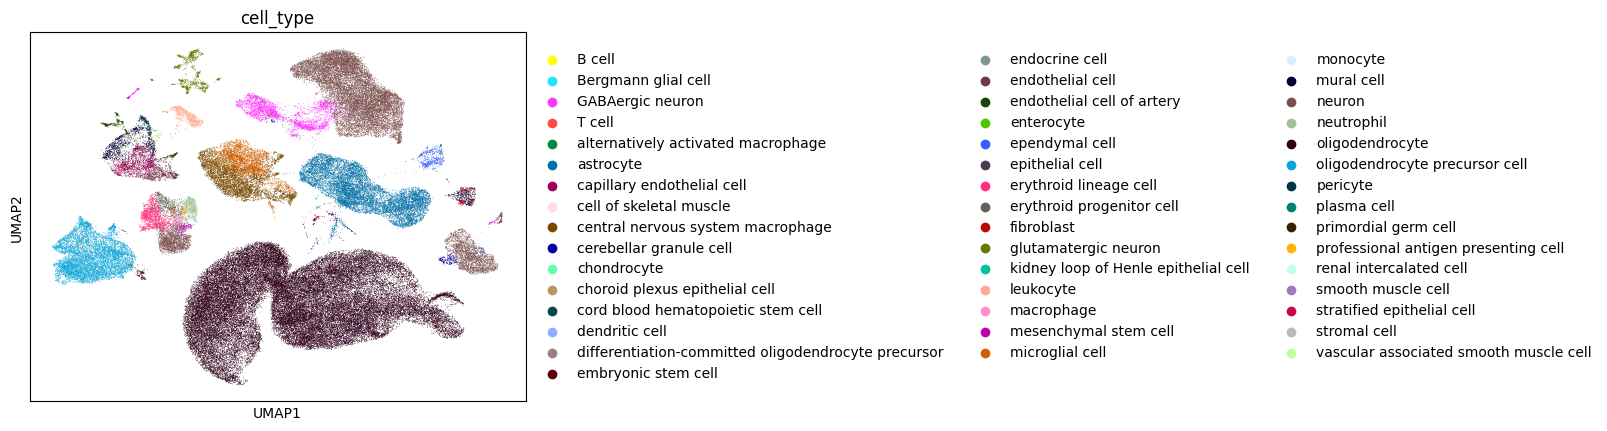

In [4]:
# plot UMAP of embedding with ScanPy
import scanpy

scanpy.pp.neighbors(adata, use_rep="an_embedding")
scanpy.tl.umap(adata)
scanpy.pl.umap(adata, color='cell_type')

## Load embeddings and fetch associated Census data

This method starts with the loaded embedding, and for each embedded cell loads metadata or X data.


In [5]:
# Load a portion of the embedding (caution: embeddings can be quite large)

import cellxgene_census
import numpy as np
import scipy.sparse as sp
import tiledbsoma as soma

# Fetch first 500_000 joinids from the embedding.
# NOTE: will fail if the there are no cells embedded within this obs joinid range
embedding_slice = (slice(500_000),)

emb_data = []
emb_joinids = []
with soma.open(EMBEDDING_URI, context=soma_context()) as E:
    # read embedding and obs joinids for each embedded cell

    for d, (obs_joinids, _) in (
        E.read(coords=embedding_slice).blockwise(axis=0, size=2**20, reindex_disable_on_axis=1).scipy()
    ):
        embedding_presence_mask = d.getnnz(axis=1) != 0
        emb_joinids.append(obs_joinids[embedding_presence_mask])
        emb_data.append(d[embedding_presence_mask, :].toarray())

    # concat
    embedding_data = np.vstack(emb_data)
    embedding_joinids = np.concatenate(emb_joinids)

# Load the associated metadata - in this case, obs.suspension_type
with cellxgene_census.open_soma(census_version=census_version) as census:
    experiment = census["census_data"][experiment_name]
    with experiment.axis_query(measurement_name="RNA", obs_query=soma.AxisQuery(coords=(embedding_joinids,))) as query:
        obs_df = query.obs(column_names=["soma_joinid", "suspension_type"]).concat().to_pandas()

# Display the first few cells, and the first few columns of their embeddings
display(obs_df[0:3])
display(embedding_data[0:3, 0:4])

,soma_joinid,suspension_type
0,0,nucleus
1,1,nucleus
2,2,nucleus


array([[-0.00761876, -0.00076538, -0.00047859, -0.03588554],
       [ 0.0040449 , -0.00239251,  0.00984829, -0.00948053],
       [ 0.00474055,  0.01356   , -0.01048549, -0.03055619]],
      dtype=float32)